<center><h1>Explore Vaccines Tweets - proxy+Labelled data
   </h1></center>

# Introduction



# Data preparation

## Load packages

In [1]:
#! yes | pip uninstall tensorflow tensorflow-gpu seaborn  lightgbm   pandas plotly  matplotlib nltk numpy gensim wordcloud textblob neattext scikit_learn nbformat transformers tensorflow_hub bert-tensorflow  tf-models-official

In [2]:
! pip install --no-cache-dir seaborn  lightgbm   pandas plotly  matplotlib nltk numpy gensim wordcloud textblob neattext scikit_learn nbformat 

In [3]:
! pip --no-cache-dir install  transformers tensorflow_hub bert-tensorflow  tf-models-official tensorflow==2.6.0  tensorflow-gpu==2.6.0

In [4]:
! pip install --no-cache-dir keras==2.6.0

In [5]:
! pip install  --no-cache-dir --upgrade tensorflow-estimator==2.6.0

In [6]:
import numpy as np 
import pandas as pd
import matplotlib as mp
import seaborn as sns
import matplotlib.pyplot as plt
#from textblob import TextBlob
%matplotlib inline 
#from wordcloud import WordCloud, STOPWORDS
##
import plotly.express as px
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
##
import warnings
warnings.simplefilter("ignore")

In [7]:
! pip list | grep tensor

bert-tensorflow               1.0.4
tensorboard                   2.7.0
tensorboard-data-server       0.6.1
tensorboard-plugin-wit        1.8.0
tensorflow                    2.6.0
tensorflow-addons             0.14.0
tensorflow-datasets           4.4.0
tensorflow-estimator          2.6.0
tensorflow-gpu                2.6.0
tensorflow-hub                0.12.0
tensorflow-metadata           1.4.0
tensorflow-model-optimization 0.7.0
tensorflow-text               2.6.0


## Load data

In [8]:
tweets_df = pd.read_csv("tweets_unlabelled_1L_proxy_labels.csv", encoding='utf-8')
train_labelled_df= pd.read_csv("clean_tweets_labelled_train.csv", encoding='utf-8')

In [9]:
tweets_df=tweets_df.append(train_labelled_df)

In [10]:
len(tweets_df)

99147

### For SSl splitting the data to 70-30  , where 30 will be used for final prediction task 





In [11]:
# seperate off train and test
#train = tweets_df.iloc[90000:, :]
#test = tweets_df.iloc[14469:, :]
train = tweets_df #.sample"(frac=0.7,random_state=200)
print(len(train))
#test=tweets_df.drop(train.index)
#print(len(test))


99147



### Classification Tasks

In [12]:
from sklearn.metrics import classification_report, f1_score, confusion_matrix,recall_score,precision_score,make_scorer
from sklearn.model_selection import StratifiedKFold, train_test_split, learning_curve,cross_val_score
# target variable 
y = train["label"].values

### Word2Vec Embeddings

In [13]:
train["label"].unique()

array([1, 2, 0])

In [14]:
pip list | grep keras

keras                         2.6.0
keras-nightly                 2.5.0.dev2021032900
Note: you may need to restart the kernel to use updated packages.


In [15]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, Bidirectional,SpatialDropout1D,GRU,Conv1D,MaxPooling1D
from tensorflow.keras import initializers, regularizers, constraints, optimizers, layers, Sequential

from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop,Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import regularizers
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint

import transformers
from tqdm.notebook import tqdm
from tokenizers import BertWordPieceTokenizer

from transformers import BertTokenizer
from  official.nlp.bert import tokenization
from transformers import TFBertModel

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import datasets

from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import History

from tensorflow.keras import losses
import tensorflow_hub as hub 

import tensorflow as tf
from tensorflow.keras.models import Model

In [16]:
def plot_training_hist(history):
    '''Function to plot history for accuracy and loss'''
    
    fig, ax = plt.subplots(1, 2, figsize=(10,4))
    # first plot
    ax[0].plot(history.history['accuracy'])
    ax[0].plot(history.history['val_accuracy'])
    ax[0].set_title('Model Accuracy')
    ax[0].set_xlabel('epoch')
    ax[0].set_ylabel('accuracy')
    ax[0].legend(['train', 'validation'], loc='best')
    # second plot
    ax[1].plot(history.history['loss'])
    ax[1].plot(history.history['val_loss'])
    ax[1].set_title('Model Loss')
    ax[1].set_xlabel('epoch')
    ax[1].set_ylabel('loss')
    ax[1].legend(['train', 'validation'], loc='best')
    


In [17]:

#from tensorflow.keras.layers import Dense, Input
#from tensorflow.keras.optimizers import Adam
#from tensorflow.keras.models import Model
#from tensorflow.keras.callbacks import ModelCheckpoint


In [18]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
    
except:
    strategy = tf.distribute.get_strategy()
    
print('Number of replicas in sync: ', strategy.num_replicas_in_sync)

Number of replicas in sync:  1


In [19]:

labels = tf.keras.utils.to_categorical(train["label"], dtype="float32")
labels

array([[0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       ...,
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.]], dtype=float32)

In [20]:

tokenizer = BertTokenizer.from_pretrained('bert-large-uncased')

def bert_encode(data, maximum_length) :
    input_ids = []
    attention_masks = []

    for text in data:
        encoded = tokenizer.encode_plus(
            text, 
            add_special_tokens=True,
            max_length=maximum_length,
            pad_to_max_length=True,

            return_attention_mask=True,
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
        
    return np.array(input_ids),np.array(attention_masks)


In [21]:
texts = train["clean_data"].values.astype('U')
target = labels


train_input_ids, train_attention_masks = bert_encode(texts,60)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [22]:


def create_model(bert_model):
    
    input_ids = tf.keras.Input(shape=(60,),dtype='int32')
    attention_masks = tf.keras.Input(shape=(60,),dtype='int32')

    output = bert_model([input_ids,attention_masks])
    output = output[1]
    output = tf.keras.layers.Dense(32,activation='relu')(output)
    output = tf.keras.layers.Dropout(0.2)(output)
    output = tf.keras.layers.Dense(3,activation='softmax')(output)
    
    model = tf.keras.models.Model(inputs = [input_ids,attention_masks],outputs = output)
    model.compile(Adam(lr=3e-5, decay = 1e-6), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [23]:

bert_model = TFBertModel.from_pretrained('bert-base-uncased')

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [24]:
bb_model = create_model(bert_model)
bb_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 60)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 60)]         0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     TFBaseModelOutputWit 109482240   input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 32)           24608       tf_bert_model[0][1]          

In [25]:
early_stopping=EarlyStopping(monitor='val_loss', patience=3)

history4 = bb_model.fit(
    [train_input_ids, train_attention_masks],
    target,
    validation_split=0.3, 
    epochs=6,
    batch_size=10,callbacks=[early_stopping]
)

Epoch 1/6
6941/6941 [==============================] - 640s 90ms/step - loss: 0.1675 - accuracy: 0.9388 - val_loss: 0.3663 - val_accuracy: 0.9208
Epoch 2/6
6941/6941 [==============================] - 629s 91ms/step - loss: 0.1026 - accuracy: 0.9615 - val_loss: 0.3359 - val_accuracy: 0.9336
Epoch 3/6
6941/6941 [==============================] - 628s 90ms/step - loss: 0.0735 - accuracy: 0.9728 - val_loss: 0.4415 - val_accuracy: 0.9335
Epoch 4/6
6941/6941 [==============================] - 628s 91ms/step - loss: 0.0501 - accuracy: 0.9828 - val_loss: 0.6275 - val_accuracy: 0.9315
Epoch 5/6
6941/6941 [==============================] - 629s 91ms/step - loss: 0.0392 - accuracy: 0.9871 - val_loss: 0.5540 - val_accuracy: 0.9293


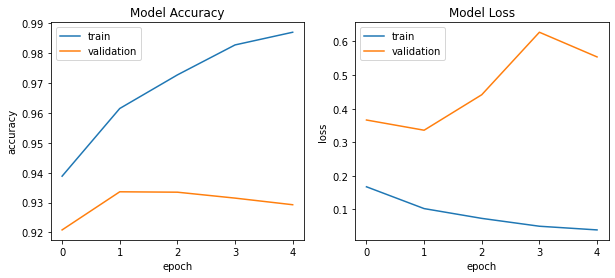

In [26]:
plot_training_hist(history4)

In [27]:
#model.save('bert_base_best_model',save_format='h5')
#print('Bert Best model saved')


# https://github.com/huggingface/transformers/issues/4444

##model.save_weights('bert_base_model_weights')

###  COVID Twitter bert 

In [28]:
#! pip install pydot graphviz
#tf.keras.utils.plot_model(model)

In [ ]:
#! pip install tensorflow_hub bert-tensorflow

#! pip install tf-models-official
#! yes |  pip uninstall  tensorflow-hub && pip install tensorflow-hub

#! yes | pip install --upgrade tensorflow-estimator==2.6.0

#! pip install --downgrade tensorflow_hub

In [ ]:
##from tensorflow.keras.layers import Dense, Input
#from tensorflow.keras.optimizers import Adam
#from tensorflow.keras.models import Model
#from tensorflow.keras.callbacks import ModelCheckpoint
#import tensorflow_hub as hub


# Load the required submodules



In [ ]:
def ct_bert_encode(texts, tokenizer, max_len=512):
    all_tokens = []
    all_masks = []
    all_segments = []
    
    for text in texts:
        text = tokenizer.tokenize(text)
            
        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len - len(input_sequence)
        
        tokens = tokenizer.convert_tokens_to_ids(input_sequence)
        tokens += [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len
        
        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)
    
    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

In [ ]:
%%time

bert_layer = hub.KerasLayer("https://tfhub.dev/digitalepidemiologylab/covid-twitter-bert/2", trainable=True)
#pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, input_type_ids])


INFO:absl:Using /tmp/tfhub_modules to cache modules.


CPU times: user 5.82 s, sys: 850 ms, total: 6.67 s
Wall time: 6.58 s


In [ ]:
def build_ct_model1(bert_layer, max_len=512):
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    input_type_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_type_ids")

    _, sequence_output = bert_layer([input_word_ids, input_mask, input_type_ids])
    clf_output = sequence_output[:, 0, :]
    output = tf.keras.layers.Dropout(0.5)((clf_output))
    output = Dense(3, activation='sigmoid')(output)
    
    model = Model(inputs=[input_word_ids, input_mask, input_type_ids], outputs=output)
    # Compile model
    model.compile(Adam(lr=2e-5,  decay = 1e-6), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
def build_ct_model(bert_layer, max_len=512):
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    input_type_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_type_ids")

    pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, input_type_ids])
    num_labels = 3
    initializer = tf.keras.initializers.TruncatedNormal(stddev=0.2)
    output = tf.keras.layers.Dropout(rate=0.2)(pooled_output)
    #output = tf.keras.layers.Dense(num_labels, kernel_initializer=initializer, name='output')(output)
    #output = tf.keras.layers.Dense(32,activation='relu')(output)
    #output = tf.keras.layers.Dropout(0.2)(output)
    #output = tf.keras.layers.Dense(3,activation='softmax')(output)

    classifier_model = tf.keras.Model(
      inputs={
              'input_word_ids': input_word_ids,
              'input_mask': input_mask,
              'input_type_ids': input_type_ids},
      outputs=output)
    classifier_model.compile(Adam(lr=2e-5, decay = 1e-6), loss='categorical_crossentropy', metrics=['accuracy'])
    return classifier_model

In [ ]:
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

In [ ]:
texts = train["clean_data"].values.astype('U')
target = labels

train_input = ct_bert_encode(texts, tokenizer, max_len=100)
train_labels = target



In [ ]:

ct_model = build_ct_model1(bert_layer, max_len=100)
ct_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_type_ids (InputLayer)     [(None, 100)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 1024), (None 335141889   input_word_ids[0][0]             
                                                                 input_mask[0][0]           

In [ ]:
#early_stopping=EarlyStopping(monitor='loss', patience=3)
#history5 = model.fit(
#    [train_input_ids, train_attention_masks],
#    target,
#    validation_split=0.2, 
#    epochs=6,
#    batch_size=10,callbacks=[early_stopping]
#)

In [ ]:
checkpoint = ModelCheckpoint('model/bert/ct_bert_model.h5', monitor='val_loss', save_best_only=True)

train_history = ct_model.fit(
    train_input, train_labels,
    validation_split=0.30,
    epochs=6,
    callbacks=[checkpoint],
    batch_size=10
)

Epoch 1/6
6941/6941 [==============================] - 2081s 296ms/step - loss: 0.2065 - accuracy: 0.9303 - val_loss: 0.3374 - val_accuracy: 0.9240
Epoch 2/6
6941/6941 [==============================] - 2055s 296ms/step - loss: 0.1147 - accuracy: 0.9561 - val_loss: 0.3612 - val_accuracy: 0.9267
Epoch 3/6
6941/6941 [==============================] - 2056s 296ms/step - loss: 0.0710 - accuracy: 0.9733 - val_loss: 0.3740 - val_accuracy: 0.9342
Epoch 4/6
6941/6941 [==============================] - 2056s 296ms/step - loss: 0.0410 - accuracy: 0.9850 - val_loss: 0.5670 - val_accuracy: 0.9345
Epoch 5/6
6941/6941 [==============================] - 2057s 296ms/step - loss: 0.0292 - accuracy: 0.9902 - val_loss: 0.4213 - val_accuracy: 0.9348
Epoch 6/6
6941/6941 [==============================] - 2058s 296ms/step - loss: 0.0216 - accuracy: 0.9929 - val_loss: 0.6465 - val_accuracy: 0.9341


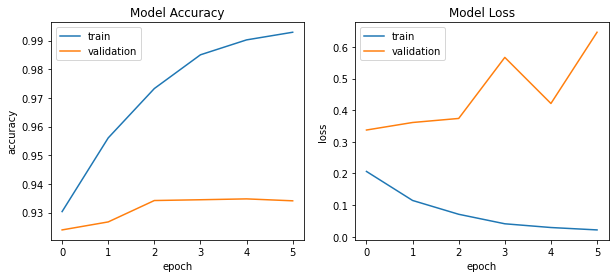

In [ ]:
plot_training_hist(train_history)